In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

with zipfile.ZipFile("/content/drive/MyDrive/signalarbeit.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/signalarbeit")

In [ ]:
import numpy as np
from numpy.fft import fft, ifft

def iaaft_surrogate(x, n_iter=100):
    """
    IAAFT yöntemiyle surrogate veri üretiyoruz burda

    x: orijinal zaman serisi
    n_iter: iterasyon sayısı (tipik olarak 100 civarı yeterlidir)
    """
    # 1. Orijinal verinin genlik sıralaması
    sorted_x = np.sort(x)

    # 2. Orijinalin genlik spektrumu
    orig_fft = fft(x)
    amplitude = np.abs(orig_fft)

    # 3. Rastgele başlangıç
    np.random.seed(0)
    y = np.random.permutation(x)

    for i in range(n_iter):
        # Fourier dönüştür
        s_fft = fft(y)

        # Orijinalin amplitüdünü kullan, yeni fazı koru
        s_fft = amplitude * np.exp(1j * np.angle(s_fft))

        # Ters Fourier
        y = np.real(ifft(s_fft))

        # Amplitüdü sırala (orijinalle aynı histogram)
        ranks = np.argsort(np.argsort(y))
        y = sorted_x[ranks]

    return y


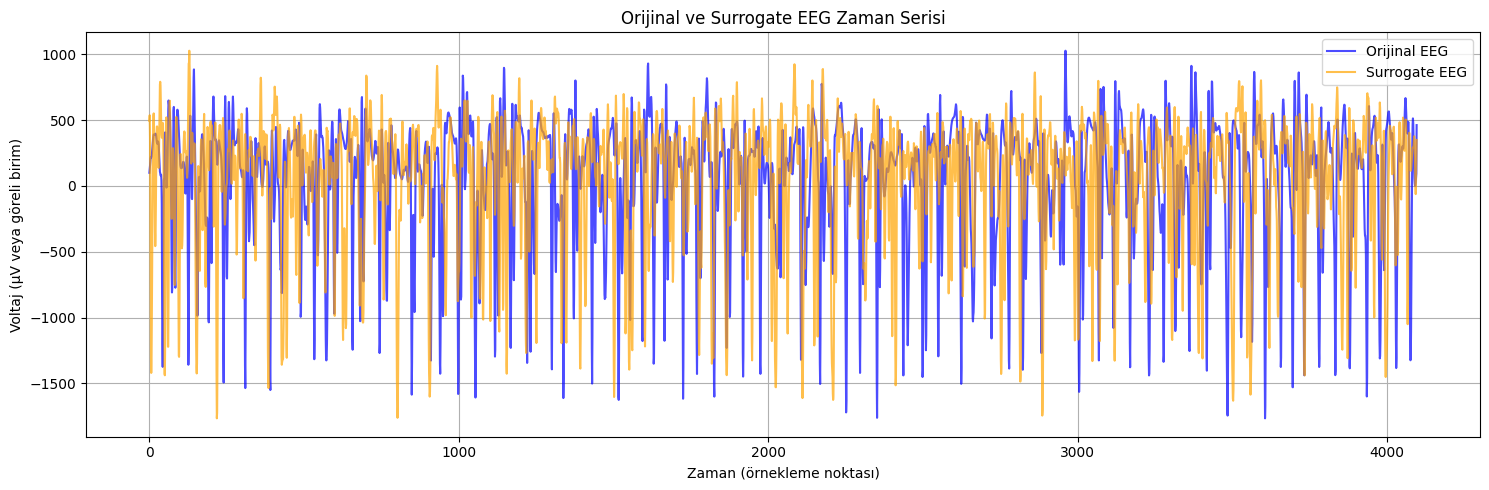

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Veri dosyasını oku
filepath = r"/content/signalarbeit/s/S001.txt"
data = np.loadtxt(filepath)#[:1000]

# Surrogate veriyi oluştur
surrogate = iaaft_surrogate(data)

# Grafiği çiz
plt.figure(figsize=(15, 5))
plt.plot(data, label="Orijinal EEG", color='blue', alpha=0.7)
plt.plot(surrogate, label="Surrogate EEG", color='orange', alpha=0.7)
plt.title("Orijinal ve Surrogate EEG Zaman Serisi")
plt.xlabel("Zaman (örnekleme noktası)")
plt.ylabel("Voltaj (µV veya göreli birim)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


burada da p değeri bakıyorum

In [ ]:
def nonlinear_prediction_error(x, m=6, tau=8, H=65, k=5):
    """
    Nonlinear Prediction Error (P) hesaplar.

    x: zaman serisi
    m: gömme boyutu (embedding dimension)
    tau: zaman gecikmesi
    H: tahmin ufku (kaç adım ileri)
    k: en yakın komşu sayısı
    """
    import numpy as np
    from scipy.spatial import KDTree

    N = len(x) - (m - 1) * tau - H
    if N <= 0:
        raise ValueError("Zaman serisi çok kısa veya H/m/tau çok büyük.")

    # Delay embedding
    embedded = np.array([
        x[i : i + m * tau : tau]
        for i in range(N)
    ])

    targets = x[(m - 1) * tau + H : (m - 1) * tau + H + N]

    # KD-tree ile en yakın k komşuyu bul
    tree = KDTree(embedded)
    pred = []

    for i in range(N):
        dists, idxs = tree.query(embedded[i], k=k+1)  # kendisi de çıkar
        valid_idxs = [j for j in idxs if j != i][:k]
        future_vals = x[(valid_idxs + np.array((m - 1) * tau + H)).tolist()]
        pred.append(np.mean(future_vals))

    pred = np.array(pred)

    # Tahmin hatası: normalize edilmiş RMS hata
    rmse = np.sqrt(np.mean((pred - targets)**2))
    baseline_rmse = np.sqrt(np.mean((targets - np.mean(x))**2))

    P = rmse / baseline_rmse
    return P


In [ ]:
# Orijinal veri
P_orig = nonlinear_prediction_error(data)

# Surrogate veri
P_surr = nonlinear_prediction_error(surrogate)

print(f"Orijinal P:  {P_orig:.4f}")
print(f"Surrogate P: {P_surr:.4f}")

if P_orig > P_surr:
    print("Orijinal veri için doğrusal olmayan hata oranı 'surrogate' hata oranından daha yüksek, tahmin edilebilirliği daha zor," \
    "çok da belirli bir düzen içerdiği kesin olarak söylenemez.")
else:
    print("'Surrogate' veri için doğrusal olmayan hata oranı Orijinal hata oranından daha yüksek, tahmin edilebilirliği daha yüksek," \
    "orijinal sinyalin 'surrogate' veriye göre daha belirli bir düzen içeriyor olma ihtimali var.")

Orijinal P:  0.9723
Surrogate P: 0.9375
Orijinal veri için doğrusal olmayan hata oranı 'surrogate' hata oranından daha yüksek, tahmin edilebilirliği daha zor,çok da belirli bir düzen içerdiği kesin olarak söylenemez.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Orijinal veri yükle
filepath = r"/content/signalarbeit/s/S001.txt"
data = np.loadtxt(filepath)

# 2. Orijinal P hesapla
P_orig = nonlinear_prediction_error(data)

# 3. Surrogate üret ve P hesapla
n_surrogates = 20
P_surr_list = []

for i in range(n_surrogates):
    surr = iaaft_surrogate(data)
    P_surr = nonlinear_prediction_error(surr)
    P_surr_list.append(P_surr)

P_surr_array = np.array(P_surr_list)

# 4. P-değeri hesapla (tek yönlü test: P_orig < P_surr)
p_value = np.sum(P_surr_array <= P_orig) / n_surrogates
p_value = p_value * 20

# 5. Sonuçları yazdır
print(f"Orijinal P: {P_orig:.4f}")
print(f"Surrogate P ortalaması: {np.mean(P_surr_array):.4f}")
print(f"P-değeri (anlamlılık olan): {p_value:.4f}")

if p_value > 0.5:
    print("Orijinal veri için doğrusal olmayan hata oranı 20 adet oluşturulmuş ve 'surrogate' hata oranından daha yüksek, tahmin edilebilirliği daha zor, \n"
    f"çok da belirli bir düzen içerdiği kesin olarak söylenemez. surrogate > orijinal sayısı: {p_value:.4f}")
else:
    print(" Surrogate veri için doğrusal olmayan hata oranı Orijinal hata oranından daha yüksek, tahmin edilebilirliği daha yüksek," + "\n" +
    f"orijinal sinyalin 'surrogate' veriye göre daha belirli bir düzen içeriyor olma ihtimali var. surrogate > orijinal sayısı: {p_value:.4f}")


Orijinal P: 0.9723
Surrogate P ortalaması: 0.9375
P-değeri (anlamlılık olan): 20.0000
Orijinal veri için doğrusal olmayan hata oranı 20 adet oluşturulmuş ve 'surrogate' hata oranından daha yüksek, tahmin edilebilirliği daha zor, 
çok da belirli bir düzen içerdiği kesin olarak söylenemez. surrogate > orijinal sayısı: 20.0000


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

data_folder = r"/content/signalarbeit/s"  # Hedef klasör (S, N, F, Z, O)
n_surrogates = 20

results = []

for filename in os.listdir(data_folder):
    if filename.endswith(".txt"):
        filepath = os.path.join(data_folder, filename)
        try:
            data = np.loadtxt(filepath)
        except Exception as e:
            print(f"{filename} okunamadı: {e}")
            continue

        print(f"\n--- {filename} ---")

        try:
            P_orig = nonlinear_prediction_error(data)
        except Exception as e:
            print(f"Orijinal sinyal için P hatası: {e}")
            continue

        P_surr_list = []
        for _ in range(n_surrogates):
            surr = iaaft_surrogate(data)
            try:
                P_surr = nonlinear_prediction_error(surr)
                P_surr_list.append(P_surr)
            except:
                continue

        P_surr_array = np.array(P_surr_list)
        p_value = np.sum(P_surr_array <= P_orig) / len(P_surr_array)

        print(f"Orijinal P: {P_orig:.4f} | Surrogate Ort: {np.mean(P_surr_array):.4f} | p-değeri: {p_value:.4f}")

        results.append({
            "dosya": filename,
            "P_orig": P_orig,
            "P_surr_mean": np.mean(P_surr_array),
            "p_value": p_value
        })



df_results = pd.DataFrame(results)
print("\nTüm Sonuçlar:")
print(df_results)

# CSV olarak dışa aktarmak istersen:
# df_results.to_csv("p_results.csv", index=False)



--- S031.txt ---
Orijinal P: 0.7410 | Surrogate Ort: 0.9233 | p-değeri: 0.0000

--- S044.txt ---
Orijinal P: 0.7910 | Surrogate Ort: 0.7717 | p-değeri: 1.0000

--- S020.txt ---
Orijinal P: 0.8233 | Surrogate Ort: 0.8949 | p-değeri: 0.0000

--- S077.txt ---
Orijinal P: 0.7983 | Surrogate Ort: 0.7865 | p-değeri: 1.0000

--- S008.txt ---
Orijinal P: 0.6373 | Surrogate Ort: 0.8463 | p-değeri: 0.0000

--- S099.txt ---
Orijinal P: 0.9459 | Surrogate Ort: 0.9667 | p-değeri: 0.0000

--- S003.txt ---
Orijinal P: 0.9804 | Surrogate Ort: 1.0100 | p-değeri: 0.0000

--- S036.txt ---
Orijinal P: 0.7953 | Surrogate Ort: 0.7383 | p-değeri: 1.0000

--- S010.txt ---
Orijinal P: 1.0638 | Surrogate Ort: 1.0335 | p-değeri: 1.0000

--- S074.txt ---
Orijinal P: 0.7733 | Surrogate Ort: 0.8715 | p-değeri: 0.0000

--- S023.txt ---
Orijinal P: 0.8245 | Surrogate Ort: 0.9045 | p-değeri: 0.0000

--- S032.txt ---
Orijinal P: 0.8231 | Surrogate Ort: 0.7453 | p-değeri: 1.0000

--- S075.txt ---
Orijinal P: 0.8148 | S

KeyboardInterrupt: 

bu kısımda da artık linear prediction error methodunu tüm sınıflarda test ediyorum.


📊 Grup Bazlı Özet:
      P_orij_mean  P_surr_mean  p_mean  n_dosya
grup                                           
f        0.608691     0.632491    0.29      100
s        0.833954     0.858003    0.39      100
z        0.883657     0.890137    0.39      100
o        0.930540     0.937965    0.35      100


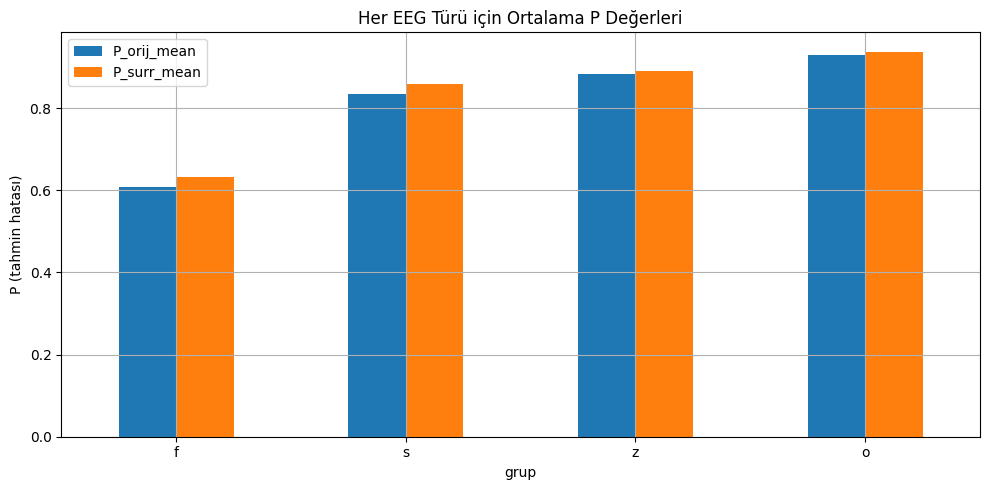

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ana klasör yolu
base_dir = r"/content/signalarbeit"
group_labels = ['s', 'f', 'z', 'o']
n_surrogates = 20

# Tüm sonuçlar burada toplanacak
all_results = []

for label in group_labels:
    group_path = os.path.join(base_dir, label)
    for filename in os.listdir(group_path):
        if filename.endswith(".txt"):
            filepath = os.path.join(group_path, filename)
            try:
                data = np.loadtxt(filepath)
                P_orig = nonlinear_prediction_error(data)
            except Exception as e:
                print(f"[{label}/{filename}] bir ssıkıntı çıktı: {e}")
                continue

            P_surr_list = []
            for _ in range(n_surrogates):
                try:
                    surr = iaaft_surrogate(data)
                    P_surr = nonlinear_prediction_error(surr)
                    P_surr_list.append(P_surr)
                except:
                    continue

            if len(P_surr_list) == 0:
                continue  # Boşsa geç

            P_surr_array = np.array(P_surr_list)
            p_val = np.sum(P_surr_array <= P_orig) / len(P_surr_array)

            all_results.append({
                "grup": label,
                "dosya": filename,
                "P_orijinal": P_orig,
                "P_surrogate_mean": np.mean(P_surr_array),
                "p_value": p_val
            })

# Tüm sonuçları pandas ile DataFrame'e dök
df = pd.DataFrame(all_results)

# Her grup için özet istatistikleri hesapla
group_stats = df.groupby("grup").agg({
    "P_orijinal": "mean",
    "P_surrogate_mean": "mean",
    "p_value": ["mean", "count"]
})
group_stats.columns = ['P_orij_mean', 'P_surr_mean', 'p_mean', 'n_dosya']
group_stats = group_stats.sort_values("P_orij_mean")

print("\n📊 Grup Bazlı Özet:")
print(group_stats)

# İstersen grafik de çizebilirsin
group_stats[['P_orij_mean', 'P_surr_mean']].plot(kind='bar', figsize=(10, 5))
plt.title("Her EEG Türü için Ortalama P Değerleri")
plt.ylabel("P (tahmin hatası)")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# S - N: sağlıklı kişiler - gözler açık ve kapalı
# F - Z - O: hasta kişiler- nöbet bölgesi ama nöbet yok - nöbet olmayan bölge nöbet yok - nöbet olan bölge nöbet var
# !!!!! bence bir grup daha olmalıydı onda da nöbet olmayan bölge nöbet zamanı olmalıydı